# Processing Sequence using RNN and CNN

In [81]:
from pathlib import Path
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def cls():
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

In [5]:
# Lets download Ridership data
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)


122880/108512 [=================================] - 0s 0us/step


'.\\datasets\\ridership.tgz'

In [7]:
# Do some preprocessing
path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


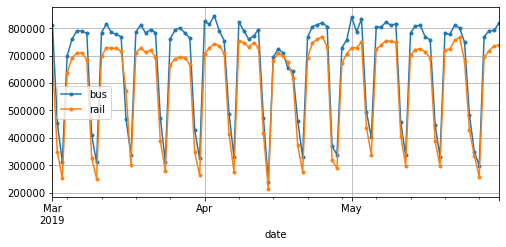

In [8]:
# Lets plot some month of 2019
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

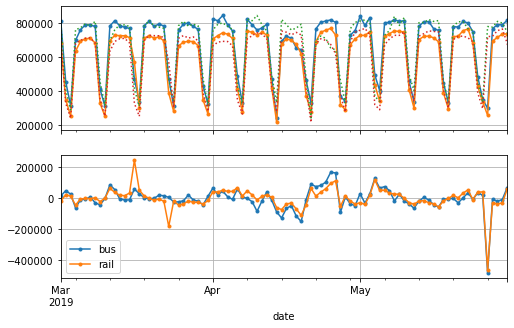

In [23]:
# To remove weekly trend
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
plt.show()

In [24]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

In [31]:
# MAPE of two series
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

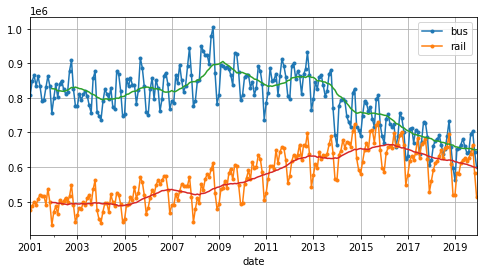

In [45]:
#Lets look at the yearly seasonality and the long term trends.

period = slice("2001", "2019")
df_monthly = df.resample('M').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()
# Green and Red is normalized or 12 month moving average value

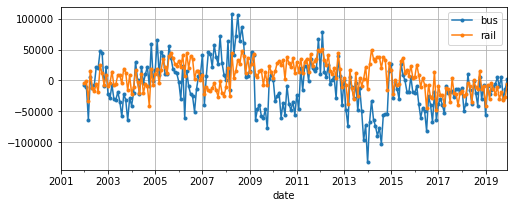

In [46]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

In [47]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()
y_pred

2019-06-01    427758.626263
Freq: D, dtype: float64

In [48]:
df["rail"].loc["2019-06-01"]  # target value

379044

In [49]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

426932

In [51]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()
mae  

32040.720104774566

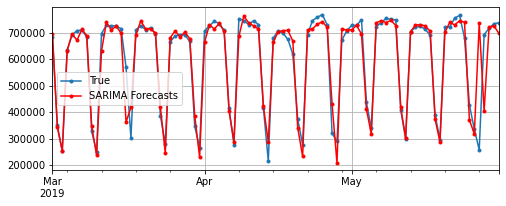

In [52]:
# Display the SARIMA forecast
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

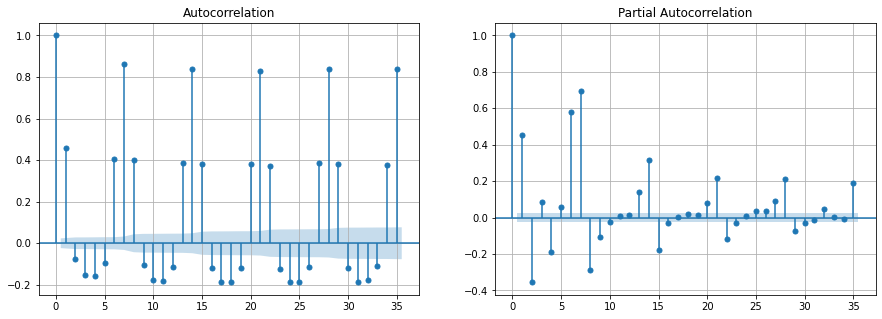

In [53]:
# Plotting the Autocorrelation Function (ACF) and the
# Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

In [55]:
########################################
# Create empty series using tensorflow #
########################################

# Here we first store the series value in array or list
my_series = [0, 1, 2, 3, 4, 5, 6]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[2, 3, 4],
         [3, 4, 5]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([5, 6])>)]

In [65]:
# Same series using tf.data module
for window_dataset in tf.data.Dataset.range(7).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 6 
4 5 6 
5 6 
6 


In [67]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [80]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

dataset = to_windows(tf.data.Dataset.range(7), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4], dtype=int64)>),
 (<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[2, 3, 4],
         [3, 4, 5]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([5, 6], dtype=int64)>)]

In [82]:
##################
# Data splitting #
##################

rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [84]:
rail_train.head() # univarient series

date
2016-01-01    0.319835
2016-01-02    0.365509
2016-01-03    0.287661
2016-01-04    0.703185
2016-01-05    0.727716
Name: rail, dtype: float64

In [85]:
seq_length = 56
cls()
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [92]:
list(train_ds)[0] # 32*56 => 32 batch 56 cotinuous sequence number

(<tf.Tensor: shape=(32, 56), dtype=float64, numpy=
 array([[0.460385, 0.357897, 0.748976, ..., 0.742502, 0.775495, 0.804635],
        [0.891357, 1.146516, 0.531687, ..., 0.292312, 0.490822, 0.537443],
        [0.46243 , 0.349892, 0.707434, ..., 0.795055, 0.788217, 0.781053],
        ...,
        [0.742346, 0.777758, 0.739069, ..., 0.430711, 0.704247, 0.735234],
        [0.694734, 0.705694, 0.716663, ..., 0.75475 , 0.421193, 0.327173],
        [0.741922, 0.760062, 0.764033, ..., 0.445282, 0.343644, 0.751951]])>,
 <tf.Tensor: shape=(32,), dtype=float64, numpy=
 array([0.528345, 0.532909, 0.464903, 0.848003, 0.758107, 0.307105,
        0.477767, 0.775495, 0.296805, 0.812195, 0.758891, 0.336109,
        0.692776, 0.690845, 0.702745, 0.773696, 0.730669, 0.742355,
        0.731858, 0.445272, 0.781151, 0.741459, 0.389791, 0.78067 ,
        0.724095, 0.751673, 0.772443, 0.752143, 0.301954, 0.732813,
        0.739174, 0.782134])>)

In [101]:
###########################################
# Lets first build a simple Linear model. #
###########################################
cls()
seq_length = 56 # or we can define (None, 56)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

model.compile(loss=tf.keras.losses.Huber(), optimizer="adam", metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=2)
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

Epoch 1/2
33/33 [==============================] - 1s 13ms/step - loss: 0.0110 - mae: 0.1215 - val_loss: 0.0108 - val_mae: 0.1132
Epoch 2/2
3/3 [==============================] - 0s 4ms/step - loss: 0.0081 - mae: 0.1010


100964.41209316254

In [98]:
###########################################
# Building the same model using RNN layer #
###########################################

#defines a utility function we'll reuse several time
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=4):
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs)
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

cls()
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/4


ValueError: in user code:

    c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:787 train_step
        y_pred = self(x, training=True)
    c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\input_spec.py:214 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, None)
